In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from PIL import Image
import joblib
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.optimize import linear_sum_assignment
import pandas as pd
from sklearn.metrics import accuracy_score
from matplotlib.colors import LogNorm

In [ ]:
def load_images_and_labels(folder): # SD: load all the images in that were generated previously from the right folder
    X, y = [], []
    class_names = sorted(os.listdir(folder))
    label_map = {cls_name: i for i, cls_name in enumerate(class_names)}
    
    for cls_name in class_names:
        cls_folder = os.path.join(folder, cls_name)
        for fname in os.listdir(cls_folder):
            img_path = os.path.join(cls_folder, fname)
            try:
                with Image.open(img_path) as img:
                    img = img.convert('L').resize(image_size) # SD: grayscale the images, then resize (this was written before I had figured out the buffer storage part in the data generation line- now the resize can be removed as all images will be of the correct size already).
                    X.append(np.array(img).flatten())
                    y.append(label_map[cls_name])
            except (OSError, ValueError) as e:
                pass
    
    return np.array(X), np.array(y), label_map

In [ ]:
# SD: when running q-transform uncomment the lines below and change the q_value
# q_value = 64
# base_dir = f'q{q_value}'
# output_tsne_file = f'tsne_q{q_value}_embeddings.pkl'
# output_plot_file = f'tsne_q{q_value}_plot.png'

# SD: when running log-mel spectrogram uncomment the lines below
base_dir = f'mel'
output_tsne_file = f'tsne_mel_embeddings.pkl'
output_plot_file = f'tsne_mel_plot.png'

# SD: should always be uncommented
image_size = (224, 224)

In [ ]:
splits = ['train', 'validation', 'test']
X_all, y_all = [], []
for split in splits:
    folder_path = os.path.join(base_dir, split)
    X_split, y_split, label_map = load_images_and_labels(folder_path)
    X_all.append(X_split)
    y_all.append(y_split)

X = np.concatenate(X_all, axis=0) # SD: for unsupervised we don't need val and test, so combining all data into giant X and y
y = np.concatenate(y_all, axis=0)

In [5]:
X = StandardScaler().fit_transform(X)

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000) # SD: running t-SNE to reduce dimensions
X_tsne = tsne.fit_transform(X)
joblib.dump((X_tsne, y, label_map), output_tsne_file) # SD: saving the t-SNE output so I don't have to rerun it if I need it again

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


['tsne_mel_embeddings.pkl']

In [ ]:
# X_tsne, y, label_map = joblib.load(f"tsne_q{q_value}_embeddings.pkl") # SD: load in t-SNE output

In [ ]:
plt.figure(figsize=(10, 8))
class_colors = sns.color_palette("tab20", 22)
for class_idx, class_name in label_map.items():
    mask = y == label_map[class_idx]
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=class_idx, s=10, c=[class_colors[class_name]]) # SD: plot points with real label values
plt.legend()
plt.title(f"t-SNE of LIGO Glitch Images (Log-Mel)") # SD: I manually changed this when I was making the log-mel one, otherwise would title with q_value instead
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize='small', markerscale=1.5) # make ledgend outside the figure
plt.tight_layout()
plt.savefig(output_plot_file, dpi=300)
plt.close()

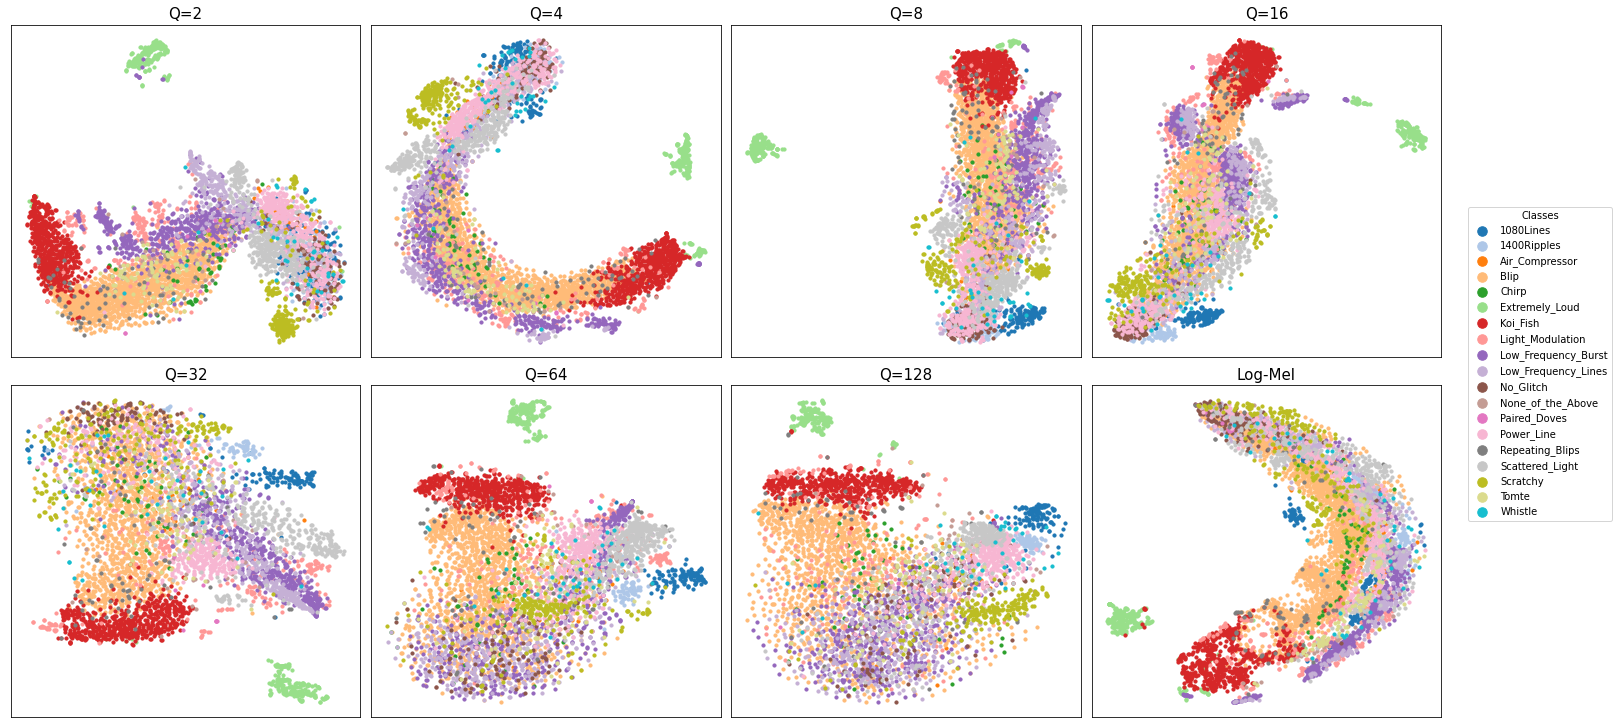

In [ ]:
# SD: code to run the graph code above but now make it one figure

q_values = [2, 4, 8, 16, 32, 64, 128]
special_name = "mel"
all_embeddings = q_values + [special_name] # SD: 8 in total

class_colors = sns.color_palette("tab20", 22)

fig, axes = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)
axes = axes.flatten()

handles = []
labels = []
collected = False

for idx, q_value in enumerate(all_embeddings):
    ax = axes[idx]
    
    # SD: load the embeddings
    if q_value == special_name:
        X_tsne, y, label_map = joblib.load(f"tsne_mel_embeddings.pkl")
        title = "Log-Mel"
    else:
        X_tsne, y, label_map = joblib.load(f"tsne_q{q_value}_embeddings.pkl")
        title = f"Q={q_value}"
    
    # SD: plot
    for class_idx, class_name in label_map.items():
        mask = y == label_map[class_idx]
        scatter = ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], s=10, color=class_colors[class_name], label=class_name if not collected else None)  # SD: making it so I only add one label
        
        if not collected:
            handles.append(scatter)
            labels.append(class_idx)
    
    ax.set_title(title, fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])
    
    collected = True  # SD: one I make a legend in first plot, don't collect legend again

# One legend outside
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.12, 0.5), fontsize='medium', markerscale=3, title='Classes')

# plt.tight_layout()
plt.savefig("combined_tsne_plots.pdf", dpi=300, bbox_inches='tight')
plt.show()

Q=2 Accuracy: 0.3431
Q=4 Accuracy: 0.3047
Q=8 Accuracy: 0.2652
Q=16 Accuracy: 0.3078
Q=32 Accuracy: 0.3284
Q=64 Accuracy: 0.3333
Q=128 Accuracy: 0.3173
Log-Mel Accuracy: 0.2326


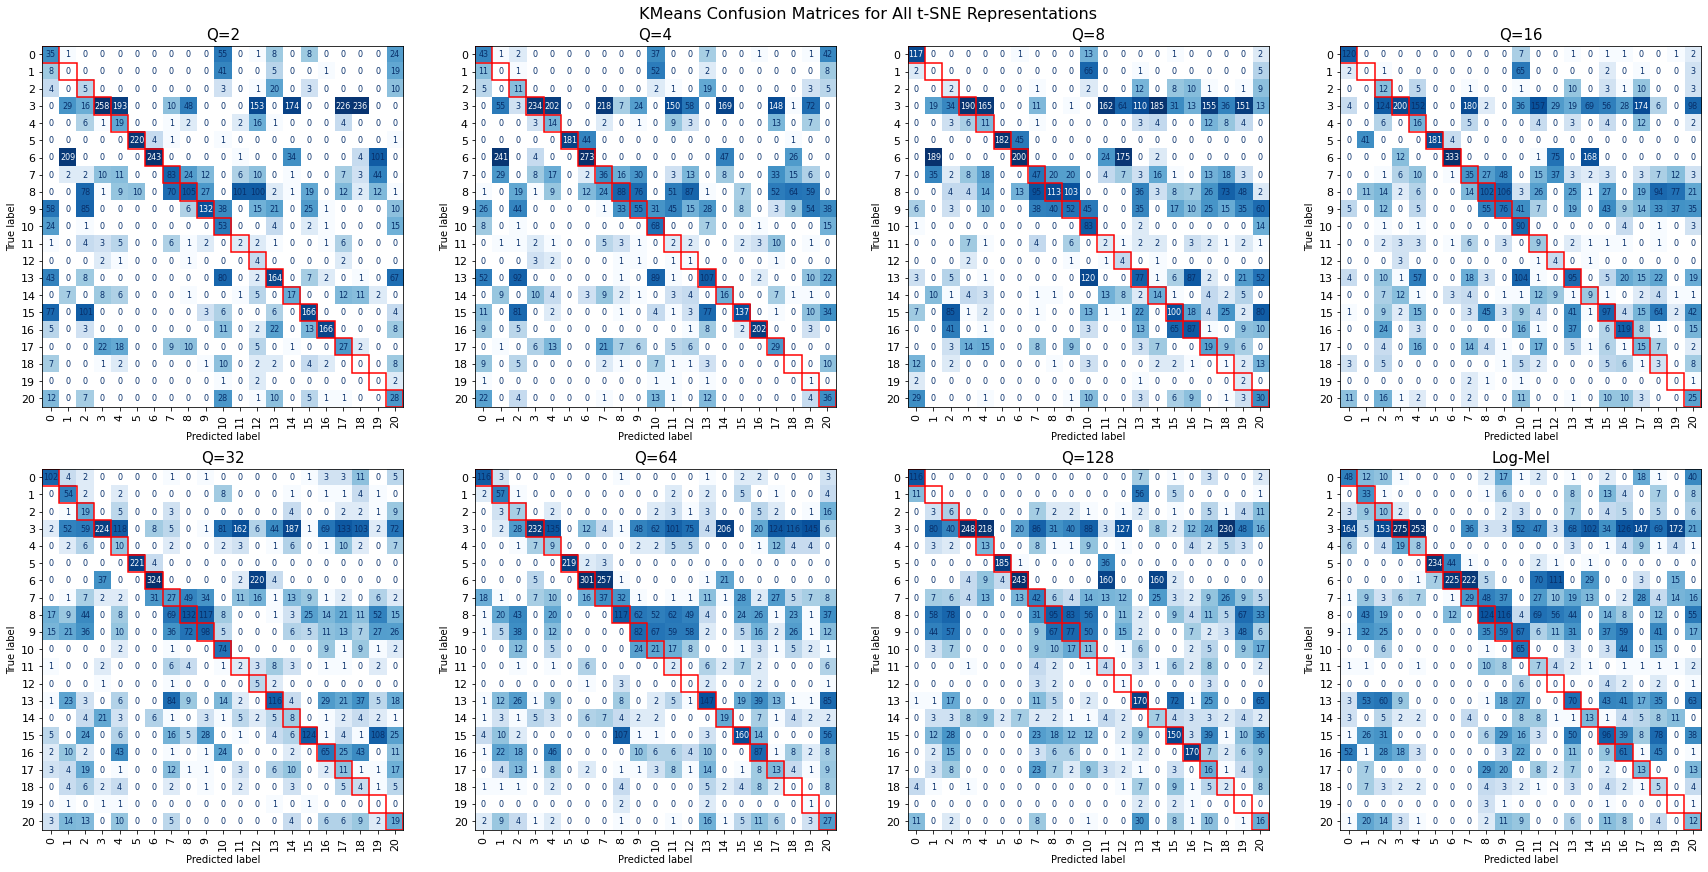

In [ ]:
# SD: code to make 1 figure with all confusion matrices

q_values = [2, 4, 8, 16, 32, 64, 128]
special_name = "mel"
all_embeddings = q_values + [special_name]  # SD: 8 in total

labels = ['1080Lines', '1400Ripples', 'Air_Compressor', 'Blip', 'Chirp', 'Extremely_Loud', 
          'Koi_Fish', 'Light_Modulation', 'Low_Frequency_Burst', 'Low_Frequency_Lines', 
          'No_Glitch', 'None_of_the_Above', 'Paired_Doves', 'Power_Line', 'Repeating_Blips', 
          'Scattered_Light', 'Scratchy', 'Tomte', 'Violin_Mode', 'Wandering_Line', 'Whistle']

# SD: create figure
fig, axes = plt.subplots(2, 4, figsize=(24, 12), constrained_layout=True)
axes = axes.flatten()

for idx, q_value in enumerate(all_embeddings):
    ax = axes[idx]
    
    # Load the embeddings
    if q_value == special_name:
        X_tsne, y, label_map_loaded = joblib.load(f"tsne_mel_embeddings.pkl")
        title = "Log-Mel"
    else:
        X_tsne, y, label_map_loaded = joblib.load(f"tsne_q{q_value}_embeddings.pkl")
        title = f"Q={q_value}"
    
    # SD: perform clustering
    n_clusters = len(np.unique(y))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    y_pred = kmeans.fit_predict(X_tsne)

    # SD: getting the correct labels by matching predicted with true labels
    conf_matrix = confusion_matrix(y, y_pred)
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)
    matched_preds = np.zeros_like(y_pred)
    for cluster_label, true_label in zip(col_ind, row_ind):
        matched_preds[y_pred == cluster_label] = true_label
    
    # SD: new confusion matrix after matching labels
    cm = confusion_matrix(y, matched_preds)
    
    # SD: accuracy calculation
    acc = accuracy_score(y, matched_preds)
    print(f"{title} Accuracy: {acc:.4f}")
    
    # SD: plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[labels[i] for i in range(n_clusters)])
    disp.plot(ax=ax, colorbar=False, cmap="Blues", xticks_rotation=90, im_kw={"norm":LogNorm(vmin=1, vmax=cm.max())}) # SD: making colourbar log scale
    ax.set_title(title, fontsize=15)

    for text in disp.text_.ravel():
        text.set_fontsize(8) # SD: making numbers smaller because the 3 digit numbers overflow into other boxes if bigger and become unreadable

    # SD: set x and y ticks to numbers instead of class names - save space as this figure is already very big and dense
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    
    ax.set_xticklabels(np.arange(len(labels)), fontsize=11)
    ax.set_yticklabels(np.arange(len(labels)), fontsize=11)

    # SD: highlight diagonal
    for i in range(len(cm)):
        ax.add_patch(plt.Rectangle((i-0.5, i-0.5), 1, 1, fill=False, edgecolor='red', lw=1.5))

plt.suptitle("KMeans Confusion Matrices for All t-SNE Representations", fontsize=16)
plt.savefig("combined_confusion_matrices.pdf", dpi=300, bbox_inches='tight')
plt.show()